# 5. Neural Network Modelling

## 5.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D

from Helpers_NN import add_sum_suffix, text_cleanup, reverse_encode, add_one_argmax_score, conf_matrix

Using TensorFlow backend.


In [2]:
sns.set_context('poster')

In [3]:
df = pd.read_csv('Data/2.hotel_reviews_structured.csv')

## 5.2 One Hot Encoding Scores Column

In [4]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['score']]).toarray())

df = df.join(enc_df)
df.head()

,hotel_name,review_summary,score,review,0,1,2,3,4
0,Hotel Hilton London Gatwick Airport,Awful...,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,Hilton London Metropole,Terrible,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,Hilton London Euston,Double deposit taken from bank,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,Hilton London Metropole,Super disappointed!,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,Hilton London Metropole,Dissatisfied Hilton gold number,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


In [5]:
df = df.rename(columns={0: "score_1", 1:'score_2',2:'score_3',3:'score_4',4:'score_5'})

In [6]:
df.head()

,hotel_name,review_summary,score,review,score_1,score_2,score_3,score_4,score_5
0,Hotel Hilton London Gatwick Airport,Awful...,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,Hilton London Metropole,Terrible,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,Hilton London Euston,Double deposit taken from bank,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,Hilton London Metropole,Super disappointed!,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,Hilton London Metropole,Dissatisfied Hilton gold number,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


## 5.3 Train Test Split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df[['review','review_summary']], 
                                                    df[['score_1','score_2','score_3','score_4','score_5']], 
                                                    test_size=.2, 
                                                    random_state=42)

## 5.4 Add Suffix to the Review Summary to Distinguish the Difference

In [8]:
x_train['review_summary_suffixed'] = x_train['review_summary'].apply(add_sum_suffix)
x_test['review_summary_suffixed'] = x_test['review_summary'].apply(add_sum_suffix)

In [9]:
x_train.head()

,review,review_summary,review_summary_suffixed
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum


## 5.5 Removing Punctuation and Tokenizing Review Column

In [10]:
x_train['review_cleaned'] = x_train['review'].apply(text_cleanup)
x_test['review_cleaned'] = x_test['review'].apply(text_cleanup)

In [11]:
x_train.head()

,review,review_summary,review_summary_suffixed,review_cleaned
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum,from arrival at check in where we had great se...
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...,after hours waiting for chosen room booked onl...
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...,the hotel is very well located five minutes wa...
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...,we stayed here a total of nights in april the ...
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum,we recently stayed at hilton gatwick south ter...


## 5.6 Creating a Dictionary With Words That Appear in Reviews and an Index

In [12]:
flat_review = " ".join(x_train['review_cleaned'].values)
flat_review = flat_review.lower().split()

In [13]:
len(flat_review)

733061

In [14]:
flat_review_summary = " ".join(x_train['review_summary_suffixed'].values)
flat_review_summary = flat_review_summary.lower().split()

In [15]:
unique_list = []
for word in flat_review:
    if word not in unique_list:
        unique_list.append(word)
for word in flat_review_summary:
    if word not in unique_list:
        unique_list.append(word)

In [16]:
len(unique_list)

17313

In [17]:
word_index_dict = {}
for i in range(0,len(unique_list)):
    word_index_dict[unique_list[i]] = i
    

In [18]:
word_index_dict = {k:(v+4) for k,v in word_index_dict.items()}
word_index_dict['<PAD>'] = 0
word_index_dict['<START>'] = 1
word_index_dict['<UNK>'] = 2
word_index_dict['<UNUSED>'] = 3

## 5.7 Indexing Words in Reviews Using Dictionary

In [19]:
def index_review_words(text):
    review_word_list = []
    for word in text.lower().split():
        if word in word_index_dict.keys():
            review_word_list.append(word_index_dict[word])
        else:
            review_word_list.append(word_index_dict['<UNK>'])

    return review_word_list 

In [20]:
x_train['preprocessed_review'] = x_train['review_cleaned'].apply(index_review_words)
x_test['preprocessed_review'] = x_test['review_cleaned'].apply(index_review_words)

In [21]:
x_train['preprocessed_review_summary'] = x_train['review_summary_suffixed'].apply(index_review_words)
x_test['preprocessed_review_summary'] = x_test['review_summary_suffixed'].apply(index_review_words)

In [22]:
x_train.head()

,review,review_summary,review_summary_suffixed,review_cleaned,preprocessed_review,preprocessed_review_summary
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum,from arrival at check in where we had great se...,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[14416, 14417]"
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...,after hours waiting for chosen room booked onl...,"[61, 62, 63, 64, 65, 42, 66, 67, 68, 69, 39, 7...","[14418, 14419, 14420, 14421, 14422, 14423, 14424]"
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...,the hotel is very well located five minutes wa...,"[33, 60, 111, 19, 112, 113, 114, 115, 116, 4, ...","[14425, 14426, 14427, 14428, 14429, 14430]"
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...,we stayed here a total of nights in april the ...,"[10, 144, 145, 22, 146, 25, 147, 8, 148, 33, 7...","[14431, 14432, 14433, 14434, 14435, 14421, 14436]"
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum,we recently stayed at hilton gatwick south ter...,"[10, 172, 144, 6, 173, 174, 175, 176, 33, 49, ...","[14437, 14438, 14439, 14440, 14441]"


## 5.8 Combining Indexed Review Summary and Indexed Review Into a Single Column Called All Preprocessed Review

In [23]:
x_train['all_preprocessed_review'] = x_train['preprocessed_review'] + x_train['preprocessed_review_summary']
x_test['all_preprocessed_review'] = x_test['preprocessed_review'] + x_test['preprocessed_review_summary']

## 5.9 Modelling

### 5.9.1 Add Padding to Reviews and Capping Reviews to Length 250 Words

In [24]:
x_train = sequence.pad_sequences(x_train['all_preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)
x_test = sequence.pad_sequences(x_test['all_preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)

### 5.9.2 Creating and Training Neural Network Model

In [25]:
model = Sequential()
model.add(Embedding(17317,16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dense(5,activation='sigmoid'))

In [26]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.2,random_state=42)

In [28]:
fitModel = model.fit(x_train,y_train,epochs=60,batch_size=250,validation_data=(x_val,y_val),verbose=0)

C:\Users\candy\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## 5.10 Testing Model

In [29]:
model.evaluate(x_val,y_val)

1505/1505 [==============================] - 0s 11us/step


[1.0130108503012165, 0.5481727719306946]

In [30]:
model.evaluate(x_test,y_test)

1881/1881 [==============================] - 0s 11us/step


[0.9927164431837631, 0.5619351267814636]

## 5.11 Look at Confusion Matrix

## 5.11.1 Reverse Encode Target Into One Column for Confusion Matrix

In [31]:
reverse_encode(y_test)

In [32]:
reverse_encode(y_val)

In [33]:
y_test_predicted = add_one_argmax_score(np.argmax(model.predict(x_test),axis=1))

### 5.11.2 Creating Confusion Matrix for Test Data

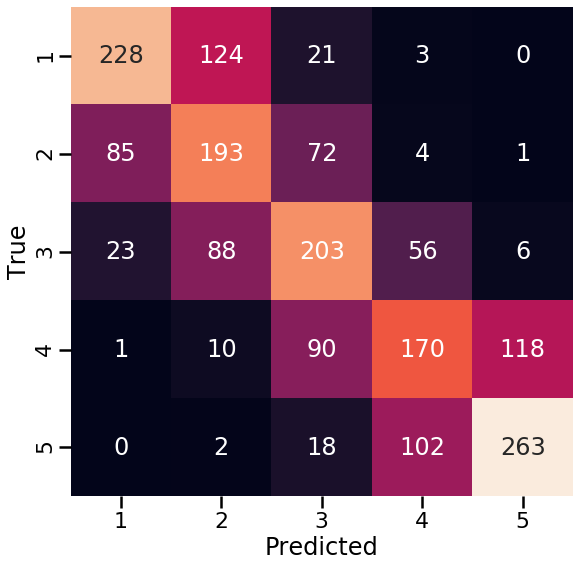

In [34]:
test_cm = confusion_matrix(y_test['score'], y_test_predicted)
conf_matrix(test_cm)